# Coherent noise studies

In [4]:
# %reset -f
import numpy as np
from LebedevHelper import *

import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate
from scipy import signal
import pickle as pkl


# Plotting preparation
import sys
sys.path.append('../')
from plot_configuration import *
np.set_printoptions(precision=3,suppress=True) 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
plt.close('all')

Finished configuring the plots.


In [5]:
# Set style of plots
# ticksize= 14
# titlesize = 18
# # mpl.style.use('classic')
# mpl.rcParams.update({'font.size':ticksize }) 
# mpl.rcParams.update({'legend.fontsize':ticksize })# legend
# mpl.rcParams.update({'ytick.labelsize':ticksize })
# mpl.rcParams.update({'xtick.labelsize':ticksize})
# mpl.rcParams.update({'axes.titlesize':titlesize})       # Title
# mpl.rcParams.update({'axes.labelsize':titlesize})    # x,y,cbar labels
# mpl.rcParams.update({'figure.titlesize' :titlesize})
# mpl.rcParams.update({'savefig.bbox':'tight'})
# mpl.rcParams.update({'axes.formatter.limits':[-3,3]})
# mpl.rcParams.update({'figure.figsize':[6,5]})
# mpl.rcParams.update({'mathtext.fontset':'cm'})
# mpl.rcParams.update({'font.style':'normal'})
# mpl.rcParams.update({'image.cmap':'rainbow'})
# mpl.rcParams.update({'axes.formatter.useoffset':False})   # no offset of axis
# mpl.rcParams.update({'axes.formatter.use_mathtext':True}) # Change from 1e4 to 10^4 

# # To use unicode
# mpl.rc('font', **{'sans-serif' : 'Arial','family' : 'sans-serif'})
# # To get sans-serif
# params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
# plt.rcParams.update(params)

%matplotlib notebook
dir_save = '01_Output/'

In [6]:
def rotation(a,b,C,S):
    temp = a
    a = C*a  + S*b
    b = -S*temp + C*b
    return a,b

def filament(a,b,dep,lim):
    ind = dep>lim
    N = np.size(a)
    phi = np.random.uniform(0,2*np.pi,np.sum(ind))
    A = np.sqrt(a**2+b**2)
    a[ind] = A[ind]*np.cos(phi)
    b[ind] = A[ind]*np.sin(phi)
    return a,b
    
def filament_lin(a,b,dep,fac=1):
    phi = np.random.uniform(0,2*np.pi,np.size(a))*dep/fac
#     A = np.sqrt(a**2+b**2)
#     a = A*np.cos(phi)
#     b = A*np.sin(phi)
    return rotation(a,b,np.cos(phi),np.sin(phi))
    
    
def kick(a,kick):
    a += kick
    return a

def noise(NN,DD):
    return np.random.randn(NN)*DD

def noise_coh(DD):
#     return np.random.uniform(-1,1)*DD
    return np.random.randn(1)*DD

def noise_sin(DD,f,t):
    return DD * np.sin(f*t)


def noise_SDSHO(xn,pn,delta,ReQ,ImQ):
    pn += np.random.randn(1) * delta  # delta = 2*|dw|*eta*sigma
    pn += pn*(ImQ*2*pi2) # ImOmega=2pi*ImQ=g/2
    temp= xn
    xn  = np.cos(pi2*ReQ)*xn   + np.sin(pi2*ReQ)*pn
    pn  =-np.sin(pi2*ReQ)*temp + np.cos(pi2*ReQ)*pn
    return xn,pn

def damper(a,b,g,w):
    b -= g*np.average(b,weights=w)
    return a,b

def damper_ideal(a,b,g,w):
    a -= g/2*np.average(a,weights=w)
    b -= g/2*np.average(b,weights=w)
    return a,b


def act(a,b,w):
    return 0.5*((a-np.average(a,weights=w))**2+(b-np.average(b,weights=w))**2)

def act_abs(a,b):
    return 0.5*((a)**2+(b)**2)

def lowpassNoise(Nx,std,dt,fl=0,fh=1):
    xt= np.random.normal(0,std,Nx)
#     xt = xt.reshape(Nx,1)
    xf= np.fft.rfft(xt)
    ff= np.fft.rfftfreq(Nx,d=dt)
    
    ind = np.logical_or(ff>=fh,ff<=fl)
    xf[ind] = 0
    xt2 = np.fft.irfft(xf,axis=0)
    xt2 = (xt2-np.mean(xt2,axis=0))*std/np.std(xt2,axis=0)
    return xt2
    

#############################################
########### Number analysis #################
def edges_to_center(edges):
    return (edges[1:]+edges[:-1])*.5


####################################################
########### Analytical predictions #################
def anal_dJxdJz(J,g2,Qp,sigdpp= 1.129E-4):
    return (1-g2)*(1-1/np.sqrt(1+2*pi2**2*(1-g2)/g2**2*Qp**2*sigdpp**2*J))

def func_g2(g):
    return g/2
#     return 1-np.sqrt(1-g+g**2*0.5)

def lebfac(g,dq):
    g2 = func_g2(g)
    return pi2**2*(1-g2)**2*(dq)**2 / (pi2**2*(1-g2)*(dq)**2  + g2**2)

def integrand_octupole(Jy,Jx,a,b,g,mJx=1,mJy=1):
    dq = a*(Jx-mJx)+b*(Jy-mJx)
    return lebfac(g,dq)*np.exp(-Jy)

def anal_dJxdJx_octu(Jx,a,b,g,mJx=1,mJy=1):
    leb = np.zeros_like(Jx)
    for i,J in enumerate(Jx):
        leb[i] = integrate.quad(integrand_octupole,0,100,args = (J,a,b,g,mJx,mJy))[0]
    return leb



def find_DiffusionSidebandWeight(sigma_x,maxOrder=10):
    """
        Function to find the weight of the sideband 
        Taken as average bessel function squared over the longitudinal gaussian distribution
    """
    xs = np.linspace(0,6,50)*sigma_x
    phi_x = xs/sigma_x**2 * np.exp(-xs**2/sigma_x**2*.5)
    
    orders = np.arange(maxOrder+1)
    factors = np.zeros(maxOrder+1)
    if sigma_x>0:
        for m in orders:
            ys=spec.jv(m,xs)
            mean = sc.integrate.simps(ys**2*phi_x,x=xs,even='first')
            factors[m]=mean
    else:
        factors[0]=1
    return factors,orders

#####################################################################
def sci_not(num,dec):
    exp = int(np.log10(num)+100)-100
    sci = (r"$%.10f"%(num/10**exp))[:dec+2+1*(dec>0)]+r"\cdot10^{%d}$"%exp
    return sci


In [7]:
delta = 1e-7
widthQ = 1e-3
print('FT = %.1e <<1 ?'%(delta/(pi2*widthQ)**1.5))

FT = 2.0e-04 <<1 ?


In [8]:
Qx=0.31
a = 1e-2
ImQ = a*.12
turns = 1e5
delta_n = 1.77020947e-3 * np.sqrt(1e4/turns)
delta_n = 0.987262819424233e-3 * np.sqrt(1e4/turns)

print('a',a)
print('ImQ',ImQ)
print('ReQ',Qx+2*a)
print('delta_n=%.5e'%delta_n)


R_D  = (pi2*ImQ)**2.5/(delta_n*a)*2
print(R_D,1/R_D, delta_n**2*turns, 1/R_D**(2/3), 1/R_D**(2/5))
print(1/(pi2*ImQ))
print(delta_n**2*turns/ImQ,'vs 15.668207838388403')

a 0.01
ImQ 0.0012
ReQ 0.33
delta_n=3.12200e-04
3.16227766016838 0.3162277660168379 0.009746878746174857 0.46415888336127786 0.6309573444801932
132.62911924324612
8.122398955145714 vs 15.668207838388403


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


tau nan inf 27.0
Analytical equilibrium= nan
Harmonic excitation:
 Wj=2.00e+00 
 tau=6.28e+02


<IPython.core.display.Javascript object>


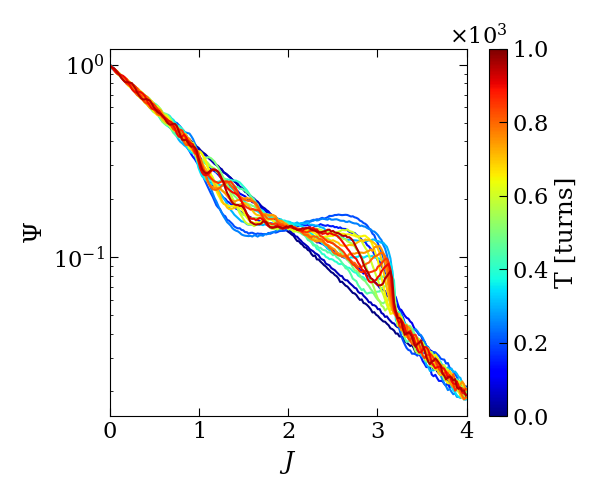

turn 0/1000 xn 0.0706127836310536
turn 100/1000 xn 0.0706127836310536
turn 200/1000 xn 0.0706127836310536
turn 300/1000 xn 0.0706127836310536
turn 400/1000 xn 0.0706127836310536
turn 500/1000 xn 0.0706127836310536
turn 600/1000 xn 0.0706127836310536
turn 700/1000 xn 0.0706127836310536
turn 800/1000 xn 0.0706127836310536
turn 900/1000 xn 0.0706127836310536
Relative actions 
 Before: Jx = 1.001 | Jz = 1.000 
 After:  Jx = 1.071 | Jz = 1.000
Absolute actions 
 Before: Jx = 1.001 | Jz = 1.000 
 After:  Jx = 1.072 | Jz = 1.000


In [38]:
N = int(1e7)
Qx = 0.31
Qy = 0.32
sigma_dpp = 1.129e-4
sigma_dpp = 1e-4
Qs = 0.002
Qp = 100 * 0

SX = np.sin(Qx*2*np.pi)
CX = np.cos(Qx*2*np.pi)
SY = np.sin(Qy*2*np.pi)
CY = np.cos(Qy*2*np.pi)
SS = np.sin(Qs*2*np.pi)
CS = np.cos(Qs*2*np.pi)
pi2 = 2*np.pi

bool_J0 = 0
bool_sinnoise = 1
bool_whitenoise = 0
bool_inconoise=0
bool_SDSHOnoise = 0
bool_noiseLF =0

bool_plotDist = 1

turns = 10**3*1
# turns = 150
turns = int(turns)
Dfac = 0
D = 1e-3  *Dfac
# D = np.sqrt(0.5/500) *.0

sep = 1e-1  * 0
# D = sep*np.sqrt(3/turns)  ; sep=0
maxj=5
# sep = np.sqrt(1/30)



gfac = 1
fac  = 1 #*10*5/2
g= 0.02  * gfac
g = -4e-4*4*np.pi
g = 0.0
a = 5e-4 * fac*gfac #*Dfac
a = 1e-3*5
b = -0.7*a *0
b = 0
# a=0

tau1 = 2/g if g>0 else np.inf
tau2 = 0.135/np.sqrt(a**2+b**2)
tau = (tau1*tau2)/(tau1+tau2)
print('tau',tau,tau1,tau2)

L = D
anal_equi = L/np.sqrt(3)*np.sqrt(tau*0.5)
print('Analytical equilibrium= %.3f'%anal_equi)

# Sinus excitation
Fh = Df = 4*a*np.sqrt(200/turns) #1e-2 *Dfac 
Fh = Df = 1e-2
Jh = 2
fnoise = 2*np.pi*(0.31+ a*Jh )
Wj = np.sqrt(np.sqrt(2*Jh)*Fh/a )
tau_h = pi2/(a*Wj)
print('Harmonic excitation:\n Wj=%.2e \n tau=%.2e'%(Wj,tau_h))

## SDSHO noise
#Force=1/wm*(w0^2-wm^2)xn
ReQ  = Qx+a*2
ImQ  = -a*0.1
AbsDw = pi2*1e-3
AbsDw = 1
sigma_n = 3e-3
eta     = 1e-1
delta_n = 2*AbsDw*eta*sigma_n  # F = 2dw<X> = delta_n
delta_n = Fh * np.sqrt(-4*pi2*ImQ) 
delta_n = 1.77e-3*np.sqrt(10000/turns)
xn = delta_n/np.sqrt(-4*(pi2*ImQ)) * np.sqrt(2) ; pn=0
xns = np.zeros(turns)

if bool_SDSHOnoise:
    print('2|dw|eta*sigma = %.5e'%delta_n)
    print('xn',xn,'ReQ',ReQ,'ImQ',ImQ)
    print('R_D = %.2e >>1'%((-pi2*ImQ)**2.5/(delta_n/2*a)))
    print('FT = %.1e <<1,%.1e  ?'%(delta_n/2/(-pi2*ImQ)**1.5,-ImQ/a))
    print('T = %.1e'%(1/(-pi2*ImQ)))
    print('F_amp = %.1e'%(delta_n/2/(-pi2*ImQ)**0.5))
    print('Q''sigma_dpp/Qs=',0 if Qp==0 else Qp*sigma_dpp/Qs)

#Low pass noise: lowpassNoise(Nx,std,dt,fl=0,fh=1)
std_LF=1e-3
frev=11245.5
cutoff=frev/2
noise_LF = lowpassNoise(int(1e5),std_LF,1/frev,frev*.2,frev*.45)


fn_savepkl = dir_save+'djxdjx0_dx%.0e_D%.0e_g%.0e_a%.0e_b%.0e_J(t)%d_Np%.0e'%(sep,D,g,a,b,1-bool_J0,N)

###########################################################
bparam = np.zeros((4,turns))
if 1:
    x = np.random.randn(N)
    p = np.random.randn(N)
    s = np.random.randn(N)
    d = np.random.randn(N)
    w = np.ones(N)
elif 0:
    Jx = np.concatenate((np.random.uniform(0,2,int(N/2)),np.random.uniform(2,6,int(N/2))))
    fx = np.random.uniform(0,pi2,N)
    Js = np.random.uniform(0,6,N)
    fs = np.random.uniform(0,pi2,N)
    
    x = np.sqrt(2*Jx)*np.cos(fx)
    p = np.sqrt(2*Jx)*np.sin(fx)
    s = np.sqrt(2*Js)*np.cos(fs)
    d = np.sqrt(2*Js)*np.sin(fs)
    w = np.ones(N)
else:
    
    jx0 = np.random.uniform(0,maxj,N)
    phix0=np.random.uniform(0,pi2,N)
    x = np.sqrt(2*jx0)*np.cos(phix0)
    p = np.sqrt(2*jx0)*np.sin(phix0)
    js0 = np.random.uniform(0,maxj,N)  *0
    phis0=np.random.uniform(0,pi2,N)
    s = np.sqrt(2*js0)*np.cos(phis0)
    d = np.sqrt(2*js0)*np.sin(phis0)
    w = np.exp(-jx0-js0)
    w = w*N/np.sum(w)
    
x0 = np.copy(x)
p0 = np.copy(p)
s0 = np.copy(s)
d0 = np.copy(d)

jx0 = act(x,p,w)   ;    jz0 = act(s,d,w)
jxa0 = act_abs(x,p);   jza0 = act_abs(s,d)


Qfil  = Qp*sigma_dpp*d
CQfil = np.cos(2*np.pi*Qfil)
SQfil = np.sin(2*np.pi*Qfil)
Qoct  = a*jxa0 + b *jza0
CQoct0 = np.cos(2*np.pi*Qoct)
SQoct0 = np.sin(2*np.pi*Qoct)




##################################
####### Define single turns ######
#         s,d = rotation(s,d,CS,SS)
#         x,p = filament(x,p,x**2 + p**2,0)
#         x,p = filament_lin(x,p,d,100)
#         x,p = filament_lin(x,p,np.sqrt(x**2 + p**2),100)
#         x,p = rotation(x,p,CQfil,SQfil)

def OTM_qp(x,p,s,d ,w):
    x,p = rotation(x,p,CX,SX)
    x,p = rotation(x,p,CQfil,SQfil)
    s,d = rotation(s,d,CS,SS)
    x,p = damper(x,p,g,w)
    return x,p,s,d 

def OTM_oct_simple(x,p,s,d,w ):
    x,p = rotation(x,p,CX,SX)
    x,p = rotation(x,p,CQoct0,SQoct0)
    x,p = damper_ideal(x,p,g,w)
#     x,p = damper(x,p,g,w)
    return x,p,s,d 

def OTM_oct(x,p,s,d ,w):
    if not bool_J0:
        jxa = act_abs(x,p)
        jza = act_abs(s,d)
        Qoct = a*jxa + b *jza
        CQoct = np.cos(2*np.pi*Qoct)
        SQoct = np.sin(2*np.pi*Qoct)
    else:
        CQoct = CQoct0
        SQoct = SQoct0

    s,d = rotation(s,d,CY,SY)
    x,p = rotation(x,p,CX,SX)
    x,p = rotation(x,p,CQoct,SQoct)
#     x,p = damper(x,p,g,w)
    x,p = damper_ideal(x,p,g,w)
    return x,p,s,d 

def OTM_oct1d_Qp(x,p,s,d,w):
#     if not bool_J0:
    jxa = act_abs(x,p)
    Qextra = a*jxa + Qp*sigma_dpp*d
    CQextra = np.cos(2*np.pi*Qextra)
    SQextra = np.sin(2*np.pi*Qextra)


    s,d = rotation(s,d,CS,SS)
    x,p = rotation(x,p,CX,SX)
    x,p = rotation(x,p,CQextra,SQextra)
    x,p = damper_ideal(x,p,g,w)

    return x,p,s,d

def OTM_oct_1D(x,p ,w):
    if not bool_J0:
        jxa = act_abs(x,p)
        Qoct = a*jxa 
        CQoct = np.cos(2*np.pi*Qoct)
        SQoct = np.sin(2*np.pi*Qoct)
    else:
        CQoct = CQoct0
        SQoct = SQoct0

    x,p = rotation(x,p,CX,SX)
    x,p = rotation(x,p,CQoct,SQoct)
#     x,p = damper(x,p,g,w)
    x,p = damper_ideal(x,p,g,w)
    return x,p

if bool_plotDist:
    plt.figure()
    norm = mpl.colors.Normalize(vmin=0, vmax=turns)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm.get_cmap(None))
    cmap.set_array([])
    turnsep = min(50,turns-1)
    
    
    
################################
########## Simulate ############
method =3
noisecount = 0
if method ==1 :
    for turn in range(turns):
        x,p = rotation(x,p,CX,SX)
        p += noise_coh(D)
        
elif method ==2:
    plt.figure()
    plt.hist2d(x,p,bins = 100)
    plt.grid(True)
    print(np.std(x)**2+np.std(p)**2)
    
    p = kick(p,1)
    plt.figure()
    plt.hist2d(x,p,bins = 100)
    plt.grid(True)
    print(np.std(x)**2+np.std(p)**2)
    
#     x,p = filament_lin(x,p,x**2 + p**2,1)
    x,p = filament_lin(x,p,d,2)
#     x,p = filament(x,p,x**2 + p**2,0)
    plt.figure()
    plt.hist2d(x,p,bins = 100)
    plt.grid(True)
    print(np.std(x)**2+np.std(p)**2)
    
elif method == 3:

    jx0s = act(x,p,w)    ;    jz0 = act(s,d,w)
    p = kick(p,sep)

    for turn in range(turns):
        if (D+Df)>0: 
            if bool_sinnoise:  p += noise_sin(Df,fnoise,turn) ; noisecount+=1
            if bool_whitenoise:
                dp = noise_coh(D)  ; 
                p += dp
                noisecount+=1 ; 
                xns[turn]=dp
            if bool_inconoise: p += noise(N,D)
            if bool_SDSHOnoise:
                xn,pn = noise_SDSHO(xn,pn,delta_n,ReQ,ImQ)
                p +=xn
                xns[turn]=xn
            if bool_noiseLF: p+=noise_LF[turn]
#         p += D/np.sqrt(3)
        
#         x,p,s,d = OTM_oct_simple(x,p,s,d,w)
#         x,p,s,d = OTM_oct(x,p,s,d,w)
        x,p = OTM_oct_1D(x,p,w)
#         x,p,s,d = OTM_oct1d_Qp(x,p,s,d,w)

#         x,p,s,d = OTM_qp(x,p,s,d,w)
        
        bparam[:,turn] = np.average([x,p,x**2,p**2],axis=1,weights=w)
        
        split = np.ceil(turns/10)
        if turn%split==0:
            print('turn %d/%d'%(turn,turns),'xn',xn)

        if bool_plotDist and (turn%turnsep)==0:
            nbin = 200
            jmax = 4
#             plt.hist(0.5*(x**2+p**2),weights = np.ones(N)/(N*jmax/(nbin-1)),bins=np.linspace(0,jmax,nbin),
#                         histtype ='step',color=cmap.to_rgba(turn+1))
            hist,xedges = np.histogram(0.5*(x**2+p**2),weights = w/(N*jmax/(nbin-1)),bins=np.linspace(0,jmax,nbin))
            plt.plot(center_edges(xedges),hist,c=cmap.to_rgba(turn+1))
elif method == 4:
    p += sep
    p += sep



jx  = act(x,p,w)  ;   jz = act(s,d,w)
jxa = act_abs(x,p);   jza = act_abs(s,d)


print('Relative actions \n Before: Jx = %.3f | Jz = %.3f \n After:  Jx = %.3f | Jz = %.3f'%(
        np.average(jx0,weights=w),np.average(jz0,weights=w),np.average(jx,weights=w),np.average(jz,weights=w)))
print('Absolute actions \n Before: Jx = %.3f | Jz = %.3f \n After:  Jx = %.3f | Jz = %.3f'%(
        np.average(jxa0,weights=w),np.average(jza0,weights=w),np.average(jxa,weights=w),np.average(jza,weights=w)))


if bool_plotDist:
    plt.xlabel(r'$J$')
    plt.ylabel(r'$\Psi$')
    fig =plt.gcf()
    cb=fig.colorbar(cmap,label='T [turns]') #ticks = np.linspace(0,tmax/time_scale,4),
    tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    plt.yscale('log')
    plt.xlim(0,4)
    plt.tight_layout()
    plt.savefig('03_Plots/dist_ts%d_Fh%.2e_a%.2e.eps'%(turnsep,Fh,a))
# Why must these be here? (below)
avgs1 = []
vars1 = []
xs1 = []
turns1 = []
dist_r1 =[]


avgs2 = []
vars2 = []
xs2 = []
turns2 = []
noisecounts=[]
dist_r2 =[]



## Initial plots

In [11]:
if 0:
    fig = plt.gcf()
    fig.set_size_inches(figwidth,figheight*.9)
    fig.tight_layout()
    plt.savefig('03_Plots/dist_ts%d_Fh%.2e_a%.2e_test.eps'%(turnsep,Fh,a))


<IPython.core.display.Javascript object>


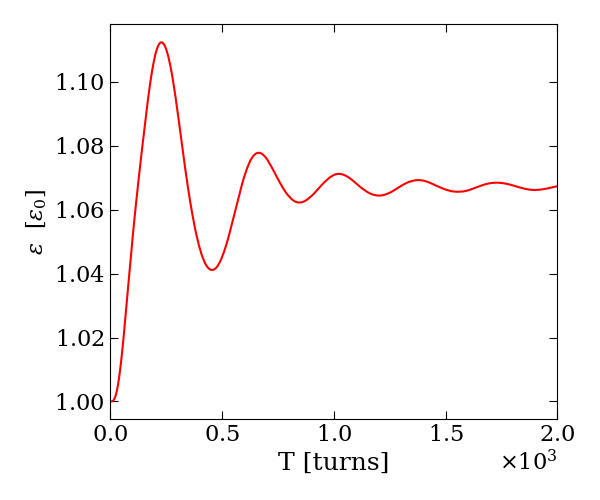

Rel emitt growth 1.0673762695741817
R_D = 3.95e-02 >>1
2|dw|etasigma=5.5972e-03


In [44]:
# Emittance plot
plt.figure(figsize=(figwidth,figheight*[.7,1][i_layout]))
plt.xlabel('T [turns]')#,fontsize=16)
plt.ylabel('Emittance',fontsize=16)
plt.ylabel(r'$\varepsilon$  $[\varepsilon_0]$')
emitt = 0.5*(bparam[2]-bparam[0]**2+bparam[3]-bparam[1]**2)
print('Rel emitt growth',emitt[-1]/emitt[0])
print('R_D = %.2e >>1'%((-pi2*ImQ)**2.5/(delta_n/2*a)))
print('2|dw|etasigma=%.4e'%delta_n)
plt.plot(emitt/emitt[0],'r',label='Emittance')
plt.xlim(0,bparam.shape[1])
plt.tight_layout()
plt.savefig('03_Plots/dedt_ts%d_Fh%.2e_a%.2e.eps'%(turnsep,Fh,a))

<IPython.core.display.Javascript object>


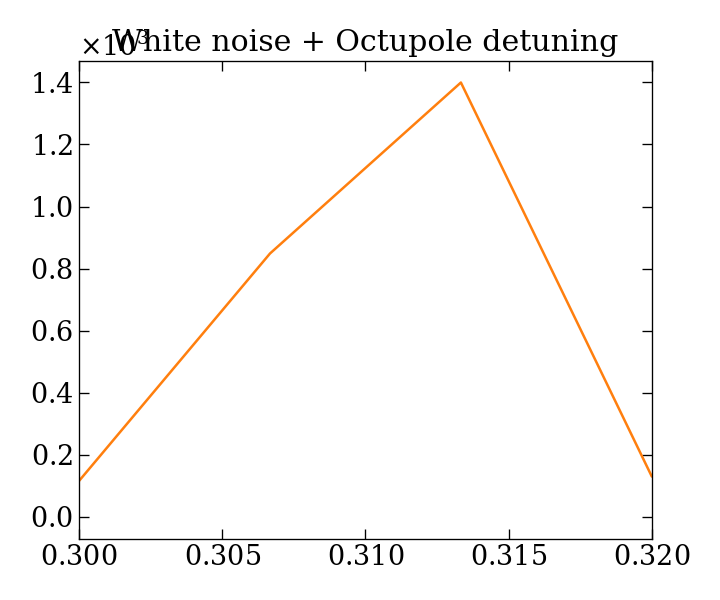

/home/sfuruset/miniconda3/lib/python3.5/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 4096 is greater than input length  = 150, using nperseg = 150
  .format(nperseg, input_length))
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


<IPython.core.display.Javascript object>


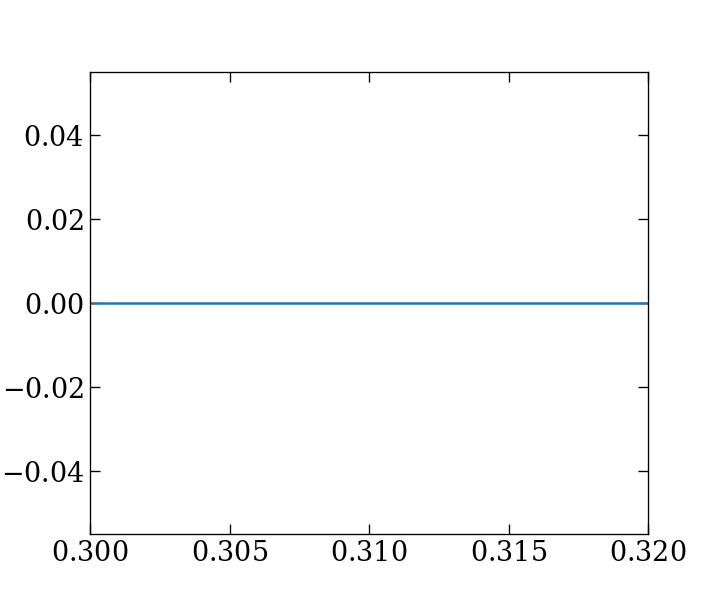

0.1 0.31 [0.    0.007 0.013 0.02  0.027 0.033 0.04  0.047 0.053 0.06  0.067 0.073
 0.08  0.087 0.093 0.1   0.107 0.113 0.12  0.127 0.133 0.14  0.147 0.153
 0.16  0.167 0.173 0.18  0.187 0.193 0.2   0.207 0.213 0.22  0.227 0.233
 0.24  0.247 0.253 0.26  0.267 0.273 0.28  0.287 0.293 0.3   0.307 0.313
 0.32  0.327 0.333 0.34  0.347 0.353 0.36  0.367 0.373 0.38  0.387 0.393
 0.4   0.407 0.413 0.42  0.427 0.433 0.44  0.447 0.453 0.46  0.467 0.473
 0.48  0.487 0.493 0.5  ]


In [19]:
# Response
plt.figure()


fftx = np.fft.rfft(bparam[0])
fftn = np.fft.rfft(xns)
psdx = np.abs(fftx)**2
psdn = np.abs(fftn)**2
f = np.fft.rfftfreq(n = turns,d=1)
nfft=1024*4
f,psdx = signal.welch(bparam[0],fs=1,nperseg=nfft,return_onesided=True)
f,psdn = signal.welch(xns,fs=1,nperseg=nfft,return_onesided=True)

QLD  = Qx+ (8.94e-04 -1.244e-03j)/1e-3*a
alpha=1.34e+00 -3.85e-01j
absalpha = abs(alpha)
pi4 = 4*np.pi

for y in [psdx/psdn, np.abs(QLD/pi2)**2/((f**2-QLD.real**2)**2+(2*QLD.real*QLD.imag)**2) *absalpha**2]:
    plt.plot(f,y)
    
plt.xlim(0.3,0.32)
plt.title('White noise + Octupole detuning')
plt.tight_layout()

plt.figure()
plt.plot(f,psdn)
plt.xlim(0.3,0.32)
print(g,Qx,f)


<IPython.core.display.Javascript object>


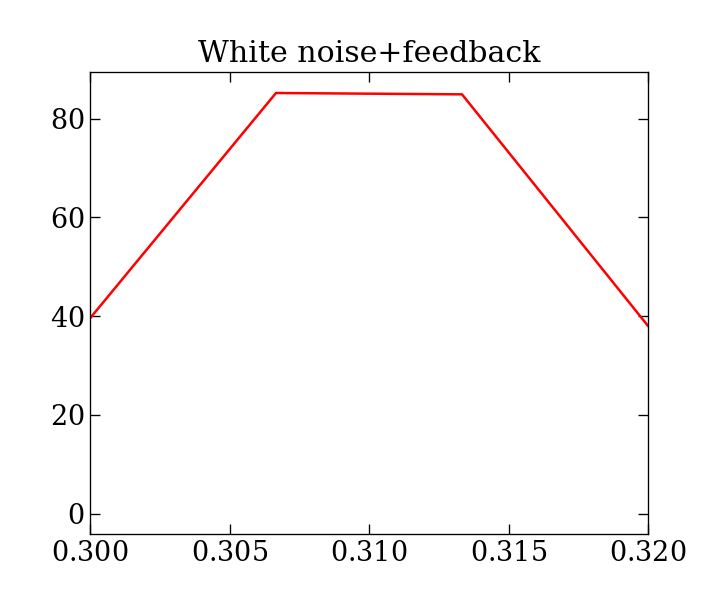

0.1 0.31 [0.    0.007 0.013 0.02  0.027 0.033 0.04  0.047 0.053 0.06  0.067 0.073
 0.08  0.087 0.093 0.1   0.107 0.113 0.12  0.127 0.133 0.14  0.147 0.153
 0.16  0.167 0.173 0.18  0.187 0.193 0.2   0.207 0.213 0.22  0.227 0.233
 0.24  0.247 0.253 0.26  0.267 0.273 0.28  0.287 0.293 0.3   0.307 0.313
 0.32  0.327 0.333 0.34  0.347 0.353 0.36  0.367 0.373 0.38  0.387 0.393
 0.4   0.407 0.413 0.42  0.427 0.433 0.44  0.447 0.453 0.46  0.467 0.473
 0.48  0.487 0.493 0.5  ]


/home/sfuruset/miniconda3/lib/python3.5/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 20480 is greater than input length  = 150, using nperseg = 150
  .format(nperseg, input_length))
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [20]:
# Response
plt.figure()


fftx = np.fft.rfft(bparam[0])
fftn = np.fft.rfft(xns)
psdx = np.abs(fftx)**2
psdn = np.abs(fftn)**2
f = np.fft.rfftfreq(n = turns,d=1)
nfft=1024*20
f,psdx = signal.welch(bparam[0],fs=1,nperseg=nfft,return_onesided=True)
f,psdn = signal.welch(xns,fs=1,nperseg=nfft,return_onesided=True)


pi4 = 4*np.pi

plt.plot(f,psdx/psdn)
# plt.plot(f,2.5e3/(1+((f**2-Qx**2)/(2*Qx*g/pi4))**2)**1)
plt.plot(f,(Qx/pi2)**2/((f**2-Qx**2)**2+(2*Qx*g/pi4)**2)**1,'r')
# plt.plot(f,psdn)
plt.xlim(0.3,0.32)
plt.title('White noise+feedback')
print(g,Qx,f)


In [21]:
if bool_SDSHOnoise:
    plt.figure()
    plt.plot(xns)
    print(delta_n/np.sqrt(-(4*pi2*ImQ)),np.std(xns))

In [22]:
#SDSHO prediction:
std_LF=1e-3
frev=11245.5
cutoff=frev/2
de_pred = 0.5*std_LF**2 * turns
de_sim  = np.average(jx,weights=w)-np.average(jx0,weights=w)
print(de_pred,de_sim)

7.5e-05 0.0040856715688522005


In [23]:
if bool_SDSHOnoise:
    fft = np.fft.rfft(xns,norm='ortho')
    PS1 = np.abs(fft)**2 * 2
    turns = turnold+turn2
    freq1=np.fft.rfftfreq(turns,d=1)
    plt.figure()
    plt.plot(freq1,PS1)
    plt.xlim(0.31,0.31+a*6)
    plt.title('PSD(Noise)')
    plt.xlabel(r'$J_x$')
    plt.xlabel(r'$Q_x$')
    plt.grid(1)
    plt.tight_layout()

    print('a=%.0e \nImQ=%.0e \nQs=%.0e \nQp=%d \nX=%.2f'%(a,ImQ,Qs,Qp,Qp*sigma_dpp/Qs))



## Track some more

In [40]:
if 1:
    bool_noise = 1
    turn2 =1000
    temp = bparam
    turnold = temp.shape[1]
    bparam = np.zeros((temp.shape[0],turnold+turn2))
    bparam[:,:turnold] = temp
    
    if bool_SDSHOnoise:
        temp = xns.copy()
        xns = np.ones(turnold+turn2)*0.0
        xns[:turnold]=temp
    
    for turn in range(turnold,turnold+turn2):
        
        if (D+Df)>0 and bool_noise:     
            if bool_sinnoise:  p += noise_sin(Df,fnoise,turn) ; noisecount+=1
            if bool_whitenoise:p += noise_coh(D)  ; noisecount+=1
            if bool_inconoise: p+= noise(N,D)
            if bool_noiseLF: p+=noise_LF[turn]
            if bool_SDSHOnoise:
                xn,pn = noise_SDSHO(xn,pn,delta_n,ReQ,ImQ)
                p +=xn
                xns[turn]=xn
#         x,p,s,d = OTM_oct_simple(x,p,s,d,w)
#         x,p,s,d = OTM_oct(x,p,s,d,w)
        x,p = OTM_oct_1D(x,p,w)
#         x,p,s,d = OTM_qp(x,p,s,d,w)
#         x,p,s,d = OTM_oct1d_Qp(x,p,s,d,w)


        bparam[:,turn] = np.average([x,p,x**2,p**2],axis=1,weights=w)
        
        split = np.ceil(turn2/5)
        if turn%split==0:
            print('turn %d/%d'%(turn,turnold+turn2))

    jx = act(x,p,w)   ;    jz = act(s,d,w)
    jxa = act_abs(x,p);   jza = act_abs(s,d)

bparam.shape
# bparam[2]

turn 1000/2000
turn 1200/2000
turn 1400/2000
turn 1600/2000
turn 1800/2000


(4, 2000)

# Standard plots

average growth: 1.461e-05


/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


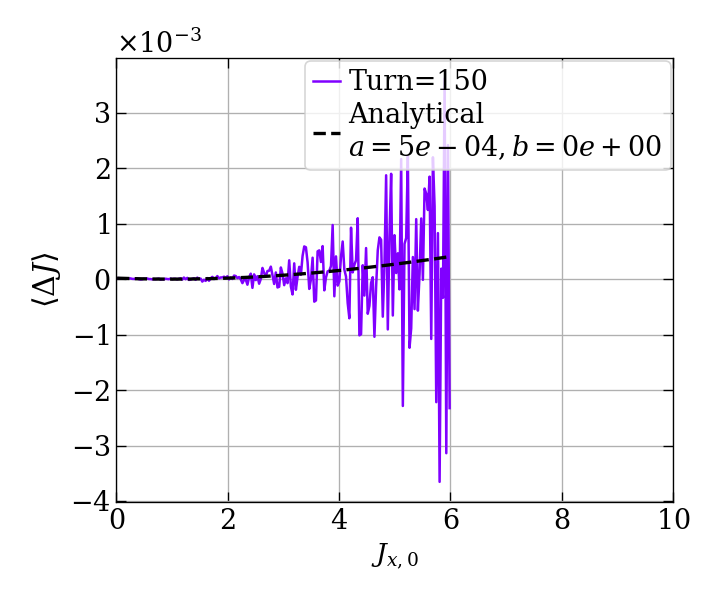

Turns=150, minimum at J_x=5.80, maximum at J_x=5.90 - width=0.09
Separation induced growth 0.005000000000000001
0.005000000000000001


<IPython.core.display.Javascript object>


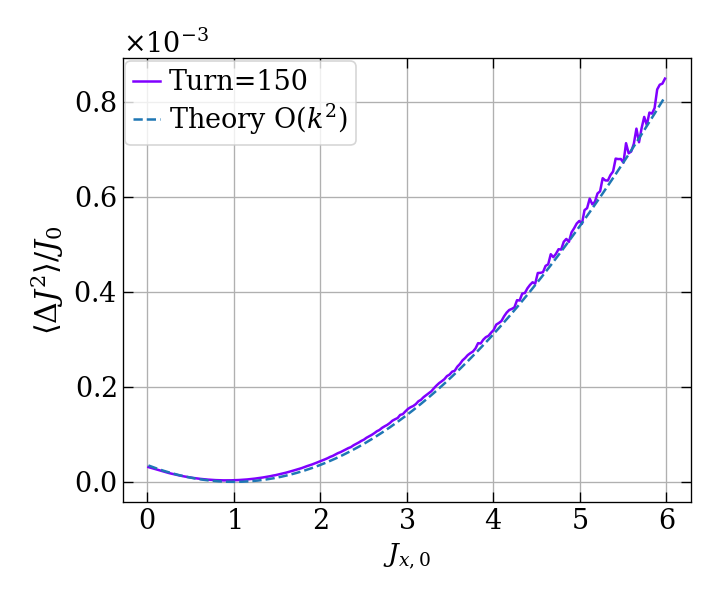

<IPython.core.display.Javascript object>


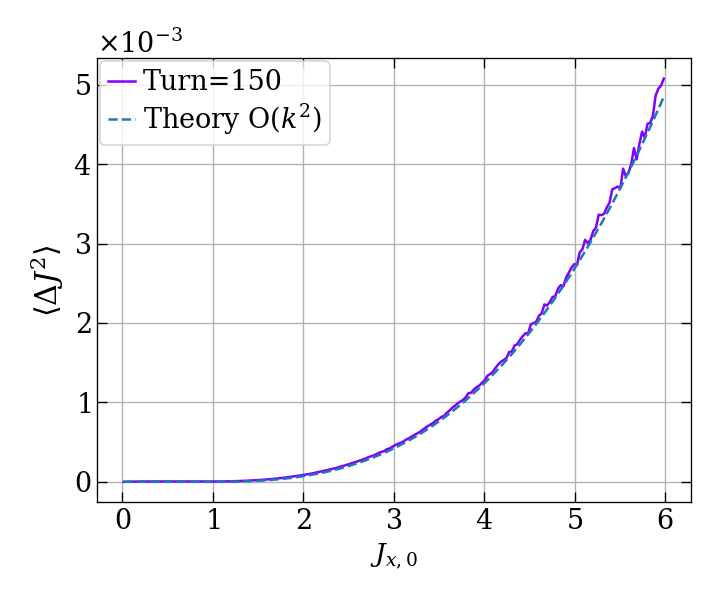

Turns=150, minimum at J_x 2.44
Turns=150: width=1.08 = 5.99-4.91
TEST  [0.015 0.045 0.075 0.105 0.135 0.165 0.195 0.225 0.255 0.285 0.315 0.345
 0.375 0.405 0.435 0.465 0.495 0.525 0.555 0.585 0.615 0.645 0.675 0.705
 0.735 0.765 0.795 0.825 0.855 0.885 0.915 0.945 0.975 1.005 1.035 1.065
 1.095 1.125 1.155 1.185 1.215 1.245 1.275 1.305 1.335 1.365 1.395 1.425
 1.455 1.485 1.515 1.545 1.575 1.605 1.635 1.665 1.695 1.725 1.755 1.785
 1.815 1.845 1.875 1.905 1.935 1.965 1.995 2.025 2.055 2.085 2.115 2.145
 2.175 2.205 2.235 2.265 2.295 2.325 2.355 2.385 2.415 2.445 2.475 2.505
 2.535 2.565 2.595 2.625 2.655 2.685 2.715 2.745 2.775 2.805 2.835 2.865
 2.895 2.925 2.955 2.985 3.015 3.045 3.075 3.105 3.135 3.165 3.195 3.225
 3.255 3.285 3.315 3.345 3.375 3.405 3.435 3.465 3.495 3.525 3.555 3.585
 3.615 3.645 3.675 3.705 3.735 3.765 3.795 3.825 3.855 3.885 3.915 3.945
 3.975 4.005 4.035 4.065 4.095 4.125 4.155 4.185 4.215 4.245 4.275 4.305
 4.335 4.365 4.395 4.425 4.455 4.485 4.515 4.545 4.57

<IPython.core.display.Javascript object>


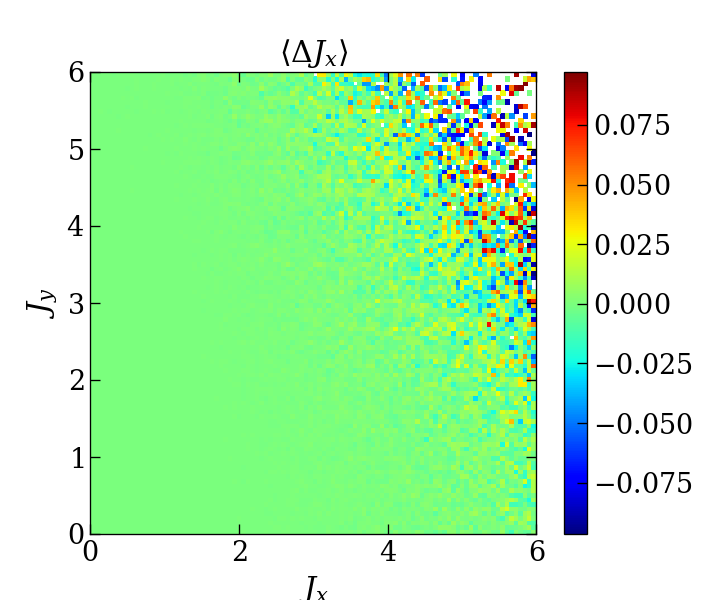

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:280: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:280: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


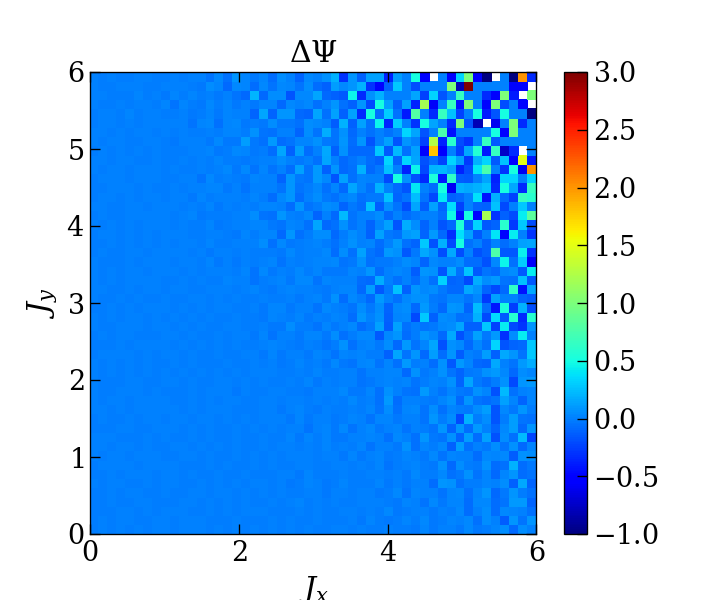

[[128166. 113391. 100791. ...    443.    382.    344.]
 [113678. 100013.  89353. ...    429.    366.    305.]
 [101022.  88901.  78647. ...    362.    307.    280.]
 ...
 [   405.    410.    355. ...      3.      1.      0.]
 [   421.    363.    322. ...      2.      1.      3.]
 [   375.    307.    276. ...      2.      2.      2.]]
Line 15x


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:296: RuntimeWarning: divide by zero encountered in true_divide


<IPython.core.display.Javascript object>


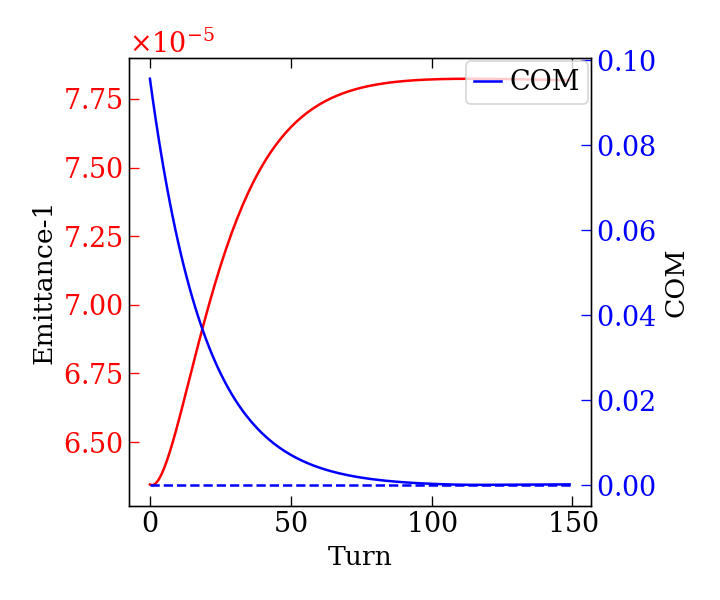

Analytical equilibrium  0.0
Numerical equilibrium   0.024969494628409642


<IPython.core.display.Javascript object>


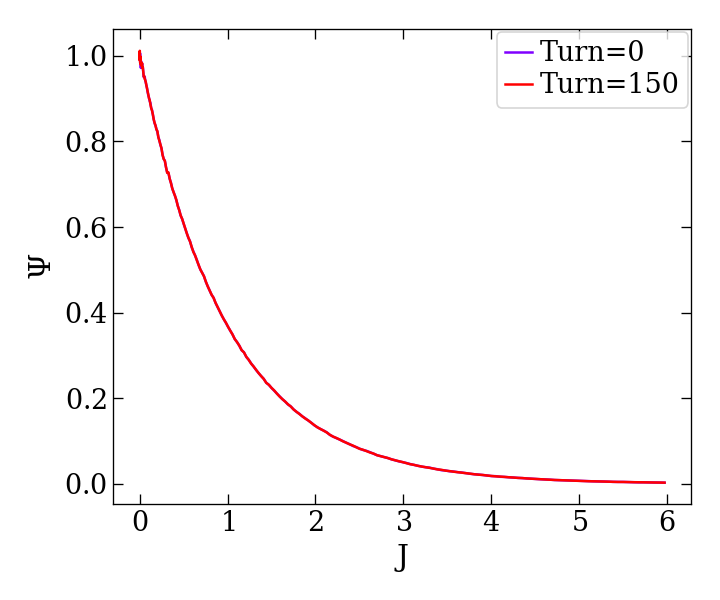

<IPython.core.display.Javascript object>


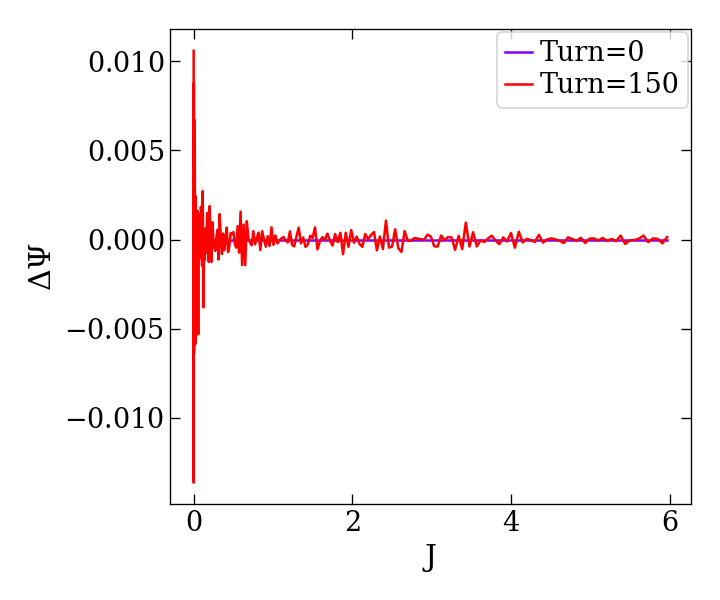

<IPython.core.display.Javascript object>


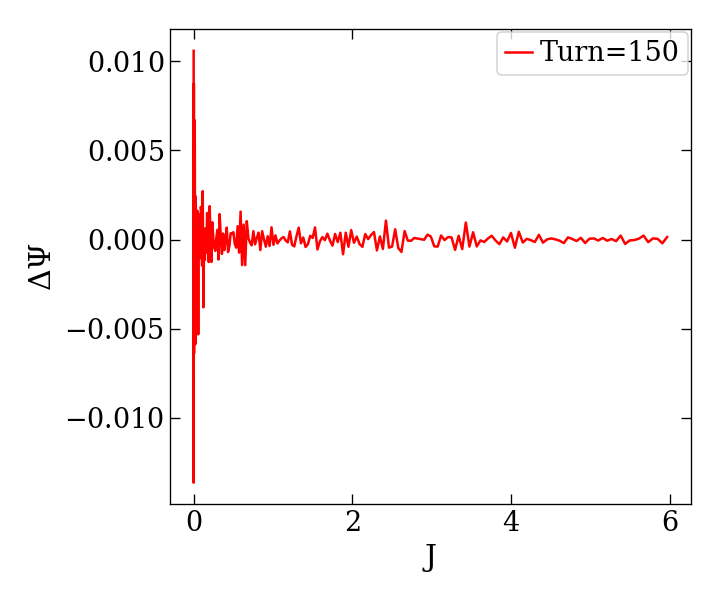

In [67]:
mJx = 1
mJy = 1
lim = 0.6*sep**2
lim=.11
xlim = 10

# b= 0



# plt.figure(figsize=(10,6))
nbin = 200
Jmax=6
bins1Dr = np.linspace(0,np.sqrt(2*Jmax),nbin)

XS = [jx0,jz0]
YS = [jx-jx0,jx-jx0]

# XS = [jxa0,jx0]
# YS = [jxa-jxa0,jx-jx0]


print('average growth: %.3e'%np.mean(YS[0]))


bool_presentation=1
calc_deltaAct = 1
plot_deltaAct2D = 0
plot_averages = 1
plot_deltaAct = 1
plot_emit_cent = 1
plot_deltaDist= 0
plot_deltaDist2= 1

bool_savepkl = 1

#for i in [1]:
if calc_deltaAct:
    for j in range(2):
        
    #     H,xedges,yedges = np.histogram2d(XS[j],YS[j],nbin,range=[[0,np.max(XS[j])],[0,np.max(YS[j])]],normed=True);
        xlims = [0,6] #[np.min(XS[j]),np.max(XS[j])]
        ylims = [np.min(YS[j]),np.max(YS[j])]
        ylims = [-0.22,0.22]
        H,xedges,yedges = np.histogram2d(XS[j],YS[j],[nbin,nbin*2],range=[xlims,ylims],weights=w ,normed=True);
    
        H = H.transpose()
        ind = np.sum(H,axis=0)>0

        vmax = H.max()
        vmin = np.min(H[H>0])

        avg = np.histogram(XS[j],weights=YS[j],bins = xedges)[0] / np.histogram(XS[j],bins = xedges)[0]
        var = np.histogram(XS[j],weights=(YS[j])**2,bins = xedges)[0] / np.histogram(XS[j],bins = xedges)[0]
        
        
        
        # Save data
        endturn = np.shape(bparam)[1]
        if j ==0:
            if not (endturn in turns1):
                avgs1 += [np.copy(avg[ind])]
                vars1 += [var[ind]]
                xs1   += [xedges[1:][ind]-np.diff(xedges)[0]*0.5]
                turns1+= [endturn]
                noisecounts+=[noisecount]
        elif j == 1:
            if not (endturn in turns2):
                avgs2 += [avg[ind]]
                vars2 += [var[ind]]
                xs2   += [xedges[1:][ind]-np.diff(xedges)[0]*0.5]
                turns2+= [endturn]
                
                
                
    #     vmin= 3e-2 ; vmax=5e2
        if plot_deltaAct2D:
            fig=plt.figure(figsize=(5,5))  #1
            ax1 = plt.subplot(111)
            
            X,Y = np.meshgrid(xedges, yedges);
            X2,Y2=np.meshgrid(edges_to_center(xedges),edges_to_center(yedges))
            pcm=plt.pcolor(X,Y,H,norm =LogNorm(vmin=vmin,vmax=vmax),cmap='rainbow');
    #         pcm=plt.contourf(X2,Y2,H,levels=np.logspace(np.log10(vmin),np.log10(vmax),100),norm =LogNorm(vmin=vmin,vmax=vmax),cmap='rainbow');
            cbar = plt.colorbar(pcm, ax=ax1 ,ticks=np.logspace(-4,4,9))#, extend='max')
            plt.xlabel([r'$J_{x,0}$',r'$J_{z,0}$'][j],fontsize=16)
            plt.ylabel(r'$\Delta J_x$',fontsize=16)

            #avg = np.average(Y[1:,1:][:,ind],weights=H[:,ind],axis =0)-np.diff(yedges)[0]*0.5
            #plt.plot(xedges[1:][ind]-np.diff(xedges)[0]*0.5,avg,'k',lw=2)
        
        
            if plot_averages: plt.plot(center_edges(xedges),avg,'k',lw=2)
        
        
            plt.grid(True)

            if j == 0 and plot_averages:
                TT = noisecount
                noiseAsSep = 0.5*L**2/3 * TT
                f = anal_dJxdJx_octu( xedges,a,b,g,1,1)
                plt.plot(xedges,f*noiseAsSep,'b--',lw=2)
                plt.plot(xedges,f*noiseAsSep + np.sqrt(2*xedges *f *2*noiseAsSep),'b--',lw=2)
            



            if j==0:
        #         plt.ylim(-0.002,0.4*.5*sep**2)
        #         plt.ylim(-0.002,0.6*.5*D**2*turns)
        #         plt.ylim(-0.1,0.6)
                plt.xlim(0,10)
    #             plt.axis([0,6,-.11,.11])

            if bool_presentation:
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                cbar.ax.tick_params(labelsize=16)
                ax1.xaxis.label.set_size(26)
                ax1.yaxis.label.set_size(26)
                ax1.set_xlim(0,6)
                ax1.set_ylim(-0.11*sep/.1,.11*sep/.1)
            ax1.axis([0,6,-0.11,0.11])
            ax1.yaxis.labelpad=-10
            plt.tight_layout()

        #     fig.subplots_adjust(left=0.2, wspace=0.6)
    

if plot_deltaAct:       
    ###############################################
    ##### Plot of emittance growth since start ####

    for j in range(2):
        if Qp==0 and j==1: continue
        plt.figure() #3+4
        plt.ylabel(r'$\langle \Delta J \rangle$')
        for i in range(len(turns1)):
            c=cm.rainbow(i/max(1,len(turns1)-1))
            if j ==0:
#                 print(np.shape(xs1[i]),np.shape(avgs1[i]))
#                 print(xs1[i],avgs1[i])

                plt.plot(xs1[i],avgs1[i],c=c,label='Turn=%d'%(turns1[i]))
                minpeak = xs1[i][np.argmin(avgs1[i][xs1[i]<8])]
                maxpeak = xs1[i][np.argmax(avgs1[i][xs1[i]<8])]
                print('Turns=%d, minimum at J_x=%.2f, maximum at J_x=%.2f - width=%.2f'%(
                        turns1[i],minpeak,maxpeak,abs(minpeak-maxpeak)))
                
            elif j==1:
                plt.plot(xs2[i],avgs2[i],c=c,label='Turn=%d'%(turns2[i]))
                print('Turns=%d, minimum at J_z %.2f'%(turns2[i],xs2[i][np.argmin(avgs2[i][xs2[i]<3])]))
        plt.xlabel([r'$J_{x,0}$',r'$J_{z,0}$'][j],fontsize=16)
#         plt.ylabel(r'$\Delta J_x$',fontsize=16)

    
        # Analytical solutions (Lebedev)
        sepanal = 0.5*sep**2
        TT=turns1[-1]
        TT= turns
        TT = noisecount
        noiseanal=0.5*anal_equi**2  * TT   /tau
        noiseAsSep = 0.5*D**2 * TT  # = 0.5 sep^2 -> L = sep*np.sqrt(3/TT)
        growth_g0 = sepanal + noiseAsSep
        if (a>0 or b>0) and Qp ==0 and not (bool_sinnoise or bool_SDSHOnoise):
            if sep >0:
                print('Separation induced growth',sepanal)
                g0growth = sepanal
                f = anal_dJxdJx_octu(xs1[i],a,b,g,mJx,mJy)
    #             f = sepanal* ( anal_dJxdJx_octu(xs1[i],a,b,g,mJx,mJy)
    #                           +anal_dJxdJx_octu(xs1[i],a,b,g,mJx*0.5,mJy*0.5)
    #                           +anal_dJxdJx_octu(xs1[i],a,b,g,mJx*0,mJy*0)) / 3
                plt.plot(xs1[i],sepanal*f,
                         'k--',lw=2,label='Analytical \n'+ r'$a=%.0e , b=%.0e$'%(a,b))        
            elif D >0:
                noiseanal=0.5*anal_equi**2  * TT   /tau
                fac=0.7
                plt.plot(xs1[i],noiseanal*anal_dJxdJx_octu(xs1[i],a*fac,b*fac,g,mJx,mJy),
                         'k--',lw=2,label=r'Analytical, %d turns, $\tau_{Tot}$'%TT+ '\n'+ r'$a=%.0e , b=%.0e$'%(a*fac,b*fac))        
                print('Noise induced growth',noiseanal,turns1)
                noiseanal=0.5*anal_equi**2  * TT   /tau2
                fac=1
                g0growth = noiseAsSep
                f = anal_dJxdJx_octu( xs1[i],a*fac*(1-j)+j*b*fac,b*fac*(1-j)+j*a*fac,g,mJx,mJy)
                plt.plot(xs1[i],noiseanal*f,
                         'k',lw=2,label=r'Analytical, %d turns, $\tau_{Dec}$'%TT+ '\n'+ r'$a=%.0e , b=%.0e$'%(a*fac,b*fac))        
                plt.plot(xs1[i],noiseAsSep*f,
                         'k-.',lw=2,label=r'Analytical, %d turns, Separation'%TT+ '\n'+ r'$a=%.0e , b=%.0e$'%(a*fac,b*fac))        
            if j==0:
                print(g0growth)
        


        elif j == 1 and Qp>0 and not (bool_sinnoise or bool_SDSHOnoise):
            # Analytical for chromaticity
            g2 = g/2

            Qpr = 0.8*Qp
            plt.plot(xs2[i],sepanal*anal_dJxdJz(xs2[i],g2,Qpr,sigdpp= 1.129E-4),
                     'k--',lw=2,label=r'Analytical $(Q^\prime=%.1f)$'%Qpr)
            plt.plot(xs2[i],sepanal*anal_dJxdJz(xs2[i],g2,Qp,sigdpp= 1.129E-4),
                     'k',lw=2,label=r'Analytical $(Q^\prime=%.1f)$'%Qp)
            
        else:
            f=0
            g0growth=0
            
        if bool_savepkl:
            with open(fn_savepkl,'wb') as file:
                pkl.dump([xs1[-1],avgs1[-1],vars1[-1],g0growth*f,[a,b,g,sep,D,TT]],file)

        plt.grid(True)
#         plt.ylim(-min(0.1*lim,0.1),lim)     ;   
        plt.xlim(0,xlim)

        plt.legend(loc=[(1,0),'best'][len(turns1)<8])
        plt.tight_layout()

##################################################
########### Average spread #######################
        figs1 = plt.figure()
        figs2 = plt.figure()
        axs1 = figs1.gca()
        axs2 = figs2.gca()
        
        axs1.set_ylabel(r'$\langle \Delta J^2 \rangle/J_0$')
        axs2.set_ylabel(r'$\langle \Delta J^2 \rangle$')
        
        for i in range(len(turns1)):
            sepanal = 0.5*sep**2
            noiseAsSep = 0.5*D**2 * noisecounts[i]
            growth_g0 = sepanal + noiseAsSep
            c=cm.rainbow(i/max(1,len(turns1)-1))
            if j ==0:
                axs1.plot(xs1[i],vars1[i]/xs1[i],c=c,label='Turn=%d'%(turns1[i]))
                axs2.plot(xs1[i],vars1[i],c=c,label='Turn=%d'%(turns1[i]))
                print('Turns=%d, minimum at J_x %.2f'%(turns1[i],xs1[i][np.argmin(avgs1[i][xs1[i]<3])]))
                peak = np.max(vars1[i])
                leftend = np.min(xs1[i][vars1[i]>peak/2])
                rightend = np.max(xs1[i][vars1[i]>peak/2])
                print('Turns=%d: width=%.2f = %.2f-%.2f'%(turns1[i],rightend-leftend,rightend,leftend))
            elif j==1:
                plt.plot(xs2[i],vars2[i],c=c,label='Turn=%d'%(turns2[i]))
                print('Turns=%d, minimum at J_z %.2f'%(turns2[i],xs2[i][np.argmin(avgs2[i][xs2[i]<3])]))
            
            if (a>0 or b>0) and Qp ==0  and j==0 and not (bool_sinnoise or bool_SDSHOnoise):
                dmu = func_dmu(a,xs1[i]-mJx+1)
                anal_spread1 = growth_g0    *2*xs1[i]* (MM(g/2,dmu)**2 + NN(g/2,dmu)**2)
                anal_spread2 = growth_g0*(LL(g/2,dmu))**2
                print('TEST ',xs1[i])
                axs1.plot(xs1[i],anal_spread1/xs1[i],'--',label=r'Theory O$(k^2)$')
                axs2.plot(xs1[i],anal_spread1       ,'--',label=r'Theory O$(k^2)$')
#                 plt.plot(xs1[i],anal_spread1+anal_spread2,':',label=r'Theory O$(k^4)$')
#                 print('what the ',i,turns1,xs1,vars1)
        for figi in [figs1,figs2]:
            axi = figi.gca()
            axi.set_xlabel([r'$J_{x,0}$',r'$J_{z,0}$'][j],fontsize=16)
            axi.legend(loc=[(1,0),'best'][len(turns1)<8])
            axi.grid(True)
            figi.tight_layout()
            
        
    # plt.figure()
    # for i in range(len(turns1)):
    #     plt.plot(xs2[i],avgs2[i],label=str(turns2[i]))
    # plt.grid(True)
    # plt.ylim(-lim,lim)    ; plt.xlim(0,xlim)
    # plt.legend(loc = (1,0))

#     break

    #### Change of distribution
    plt.figure() #5
    nbin2=100
    DJx = jx-jx0
    # H3,xedges,yedges = np.histogram2d(Jx0,Jy0,nbin2,range=[[0,Jmax],[0,Jmax]],weights=DJx);
    W,xedges,yedges = np.histogram2d(jx0,jz0,nbin2,range=[[0,Jmax],[0,Jmax]],weights=w); #weights=1
    H3,xedges,yedges = np.histogram2d(jx0,jz0,nbin2,range=[[0,Jmax],[0,Jmax]],weights=DJx);
    X,Y = np.meshgrid(xedges,yedges)
    F=(H3/W).transpose()
    vmax =np.nanmax(np.abs(F))
    vmin=np.nanmin(F)
    plt.pcolor(X,Y,F,vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.xlabel(r'$J_x$')
    plt.ylabel(r'$J_y$')
    plt.title(r'$\langle \Delta J_x\rangle$')
    
    #### Change of distribution
    plt.figure() #5
    nbin2=50
    Jmax=6
    # H3,xedges,yedges = np.histogram2d(Jx0,Jy0,nbin2,range=[[0,Jmax],[0,Jmax]],weights=DJx);
    H0,xedges,yedges = np.histogram2d(jxa0,jza0,nbin2,range=[[0,Jmax],[0,Jmax]])
    H1,xedges,yedges = np.histogram2d(jxa ,jza ,nbin2,range=[[0,Jmax],[0,Jmax]])
    H3 = (H1-H0)/H0
    
    X,Y = np.meshgrid(xedges,yedges)
    F=(H3).transpose()
    F = np.ma.masked_where(np.isnan(F), F)

    vmax =np.nanmax(np.abs(F))
    vmin=np.nanmin(F)
    plt.pcolor(X,Y,F)#,vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.xlabel(r'$J_x$')
    plt.ylabel(r'$J_y$')
    plt.title(r'$ \Delta \Psi$')
    print(H1)
    
if plot_emit_cent:
    ############################################
    ############################################
    
    def fit_2(x,a):
        return a*x**2
    def fit_20(x,a,b):
        return a*x**2+b
    def fit_e20(x,a):
        return np.exp(a*x**2)
    def fit_3(x,a):
        return a*x**3
    def fit_e(x,a,b):
        return a*(np.exp(x/b)-1 )

    
    print('Line 15x')
    plt.figure()  #7
    ax1 = plt.subplot(111)
    ax1.set_xlabel('Turn',fontsize=16)
    ax1.set_ylabel('Emittance-1',fontsize=16)
    ind = bparam[2,:]>0
    emitt = 0.5*(bparam[2,ind]-bparam[0,ind]**2+bparam[3,ind]-bparam[1,ind]**2)
    ax1.plot(emitt-1,'r',label='Emittance')
    ax1.tick_params('y', colors='r')

    ax2 = ax1.twinx()
    ax2.set_ylabel('COM',fontsize=16)
    COM = np.sqrt(bparam[0,ind]**2+bparam[1,ind]**2)
    ax2.plot(COM,'b',label='COM')
    ax2.plot(np.ones(turns2[-1])*anal_equi,'b--')
    ax2.tick_params('y', colors='b')
    
    if 0:
        ts = np.arange(np.size(COM))
        fits= np.polyfit(ts,np.log(COM),deg=1)
        ax2.plot(ts, np.exp(ts*fits[0]+fits[1]),label='fit d=10')
        print('COM fit*1000/pi2:',fits*1000/pi2)
        fits= np.polyfit(ts,np.log(COM),deg=2)
        ax2.plot(ts, np.exp(ts**2*fits[0]+ts*fits[1]+fits[2]),label='fit d=210')
        print('COM fit*1000/pi2:',fits*1000/pi2)  
    #     ax2.plot(ts,COM)
    #     ax2.plot(ts,COM[0]*fit_e20(ts,-0.000004))  
        fit2,cov2 = scipy.optimize.curve_fit(fit_e20, ts, (COM/COM[0]))
        ax2.plot(ts,COM[0]*(fit_e20(ts,fit2[0])),label=r'fit d=20')
        print('COM fit*1000/pi2',fit2*1000/pi2)

        print('sqrt(a^2+b^2)*1000',np.sqrt(a**2+b**2)*1000)

    
    plt.legend()
    plt.tight_layout()
    print('Analytical equilibrium ',anal_equi)
    print('Numerical equilibrium  ',np.sqrt(np.mean(COM**2)))


    emit_growth = np.diff(emitt)
    COM_mean = 0.5*(COM[1:]+COM[:-1])
    
###################################################
###################################################
###################################################
if plot_deltaDist:
    
    fig=plt.figure(figsize=(14,6))  #6
    ax1 = fig.add_subplot(121)
    ax1.hist2d(x,p,bins = 100,weights=w)
    ax1.grid(True)
    ax1.set_title("Figure 2")

    ax2 = fig.add_subplot(122)
    if 0:
        ax2.hist(x,bins=nbin,histtype='step',label='x',weights=w)
        ax2.hist(p,bins=nbin,histtype='step',label='p',weights=w)
    else:
        bins = np.linspace(0,np.sqrt(12),nbin)
        norm = edges_to_center(bins)
        ax2.plot(norm, np.histogram(np.sqrt(jxa0*2),bins=bins,weights=w,normed=True)[0]/norm,label='J0')
        ax2.plot(norm, np.histogram(np.sqrt(jxa *2),bins=bins,weights=w,normed=True)[0]/norm,label='J(t)')
#         ax2.hist(np.sqrt(2*jxa0),bins=bins,histtype='step',label='J(t=0)',weights=w)
#         ax2.hist(np.sqrt(2*jxa),bins=bins,histtype='step',label='J(t)',weights=w)
#         ax2.set_yscale('log')
    ax2.legend(loc=0)

    
    # Calculate deltadist
    norm = edges_to_center(bins1Dr)
    if  len(dist_r1)<=len(turns1):
        if len(dist_r1)==0:
            dist_0 = np.histogram(np.sqrt(jxa0*2),bins=bins1Dr,weights=w,normed=True)[0]/norm
            dist_r1+=[dist_0]
        dist_r = np.histogram(np.sqrt(jxa*2),bins=bins1Dr,weights=w,normed=True)[0]/norm
        dist_r1 +=[dist_r]
        turns_dist = [0]+turns1
    
    plt.figure()
    plt.xlabel(r'r')
    plt.ylabel(r'$\Psi$')
#     plt.plot(norm,,c=c,label='Turn=%d'%(turns1[i]))
    for i in range(len(turns_dist)):
        c=cm.rainbow(i/max(1,len(turns_dist)-1))
        if 1:
            plt.plot(norm,dist_r1[i],c=c,label='Turn=%d'%(turns_dist[i]))
        else: 
            J = 0.5*norm**2
            psiJ = dist_r1[i]*norm*np.diff(bins1Dr)/np.diff(.5*bins1Dr**2)
            plt.semilogy(J,psiJ,c=c,label='Turn=%d'%(turns_dist[i]))
        
    plt.legend(loc=[(1,0),'best'][len(turns1)<8])
    plt.tight_layout()
    
    ####
    # plt.figure()
    if False:
        plt.figure()
        for j in range(4):
            plt.subplot(221+j)
            plt.plot(bparam[j,:10])


    COM_mean = COM[:-1]
    plt.figure()
    plt.plot(COM_mean ,emit_growth,'.')
    fit2,cov2 = scipy.optimize.curve_fit(fit_2,COM_mean, emit_growth)
    plt.plot(COM_mean,fit_2(COM_mean,fit2),label=r'$a\cdot x^2$')
    err2 = np.sqrt(np.mean((emit_growth-fit_2(COM_mean,fit2))**2))

    fit3,cov3 = scipy.optimize.curve_fit(fit_3,COM_mean, emit_growth)
    err3 = np.sqrt(np.mean((emit_growth-fit_3(COM_mean,fit3))**2))
    plt.plot(COM_mean,fit_3(COM_mean,fit3),label=r'$a\cdot x^3$')

    fite,cove = scipy.optimize.curve_fit(fit_e,COM_mean, emit_growth)
    erre = np.sqrt(np.mean((emit_growth-fit_e(COM_mean,fite[0],fite[1]))**2))
    plt.plot(COM_mean,fit_e(COM_mean,fite[0],fite[1]),label=r'$a\cdot e^{x/b}$')

    ana_emit_growth = 0.5*COM_mean**2 /tau2 
    plt.plot(COM_mean,ana_emit_growth,label='ana')
    erra = np.sqrt(np.mean((emit_growth-ana_emit_growth)**2))
    plt.ylabel(r'$\Delta \epsilon $ per turn',fontsize=16)
    plt.xlabel('COM',fontsize=16)
    plt.legend(loc=0)
    plt.tight_layout()

    print('rms error, x^2',err2,' | fit',fit2)
    print('rms error, x^3',err3,' | fit',fit3)
    print('rms error, e^x',erre,' | fit',fite)
    print('rms error, ana',erra)


    seploc=0.5

    ### Action growth per x,p
    plt.figure()
    vmax = 0.5*sep**2 * 2
    vmax = sep/4
    n = min(N,int(1e4))
    plt.scatter(x0[:n],p0[:n],c=((jx-jx0)/np.sqrt(jx0))[:n],edgecolors='Face',vmin=-vmax,vmax=vmax)
    plt.colorbar()
    plt.title('Simulation')
    
    plt.figure()
    maxX=5
    W,xedges,yedges = np.histogram2d(x0,p0,nbin2,range=[[-maxX,maxX],[-maxX,maxX]]); #weights=1
    H3,xedges,yedges = np.histogram2d(x0,p0,nbin2,range=[[-maxX,maxX],[-maxX,maxX]],weights=(jx-jx0)/np.sqrt(2*jx0));
    H3=(H3/W).transpose()
    X,Y = np.meshgrid(xedges,yedges)
    F=H3
    F = np.ma.masked_where(np.isnan(F), F)
    vmax = sep
    vmin=-vmax
    plt.pcolor(X,Y,F,vmin=vmin,vmax=vmax)
    plt.colorbar()

    plt.title(r'Simulation (realistic), $\Delta$J')
    plt.xlabel(r'$x_0$') ; plt.ylabel(r'$p_{0}$')
    plt.tight_layout()
    
if plot_deltaDist2:
    
    
    
#     plt.figure()
#     ax2 = plt.gca()
#     if 0:
#         ax2.hist(x,bins=nbin,histtype='step',label='x',weights=w)
#         ax2.hist(p,bins=nbin,histtype='step',label='p',weights=w)
#     else:
#         bins = np.linspace(0,np.sqrt(12),nbin)
#         norm = edges_to_center(bins)
#         ax2.plot(norm, np.histogram(np.sqrt(jxa0*2),bins=bins,weights=w,normed=True)[0]/norm,label='J0')
#         ax2.plot(norm, np.histogram(np.sqrt(jxa *2),bins=bins,weights=w,normed=True)[0]/norm,label='J(t)')
        
    # Calculate deltadist
    norm = edges_to_center(bins1Dr)
    if  len(dist_r1)<=len(turns1):
        if len(dist_r1)==0:
            dist_0 = np.histogram(np.sqrt(jxa0*2),bins=bins1Dr,weights=w,normed=True)[0]/norm
            dist_r1+=[dist_0]
        dist_r = np.histogram(np.sqrt(jxa*2),bins=bins1Dr,weights=w,normed=True)[0]/norm
        dist_r1 +=[dist_r]
        turns_dist = [0]+turns1
    
    fig1 = plt.figure()
    plt.xlabel(r'J')
    plt.ylabel(r'$\Psi$')
    ax1 = plt.gca()
    
    fig2 = plt.figure()
    plt.xlabel(r'J')
    plt.ylabel(r'$\Delta\Psi$')
    ax2 = plt.gca()
    
    fig3 = plt.figure()
    plt.xlabel(r'J')
    plt.ylabel(r'$\Delta\Psi$')
    ax3 = plt.gca()
    
    
#     plt.plot(norm,,c=c,label='Turn=%d'%(turns1[i]))
    for i in range(len(turns_dist)):
        c=cm.rainbow(i/max(1,len(turns_dist)-1))
        if 0:
            plt.plot(norm,dist_r1[i],c=c,label='Turn=%d'%(turns_dist[i]))
        else: 
            J = 0.5*norm**2
            psiJ = dist_r1[i]*norm*np.diff(bins1Dr)/np.diff(.5*bins1Dr**2)
            psiJ0= dist_r1[0]*norm*np.diff(bins1Dr)/np.diff(.5*bins1Dr**2)
            ax1.plot(J,psiJ,c=c,label='Turn=%d'%(turns_dist[i]))
            ax2.plot(J,psiJ-psiJ0,c=c,label='Turn=%d'%(turns_dist[i]))
            if i>0:
                psiJprev= dist_r1[i-1]*norm*np.diff(bins1Dr)/np.diff(.5*bins1Dr**2)
                ax3.plot(J,psiJ-psiJprev,c=c,label='Turn=%d'%(turns_dist[i]))
    
    for i in range(3):
        ax=[ax1,ax2,ax3][i]
        ax.legend(loc=[(1,0),'best'][len(turns1)<8])
        fig = [fig1,fig2,fig3][i]
        fig.tight_layout()

In [ ]:
# print(np.shape(dist_r1))
# print(np.shape(norm))
# print(len(turns1))
# print(dist_r1[1])

# Plot for single particle chromaticity dependence

In [7]:
print(np.size(vars1))
print(ReQ,ImQ)

0
0.32 -0.0005


X 0.0
factors: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
orders:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  app.launch_new_instance()


<IPython.core.display.Javascript object>


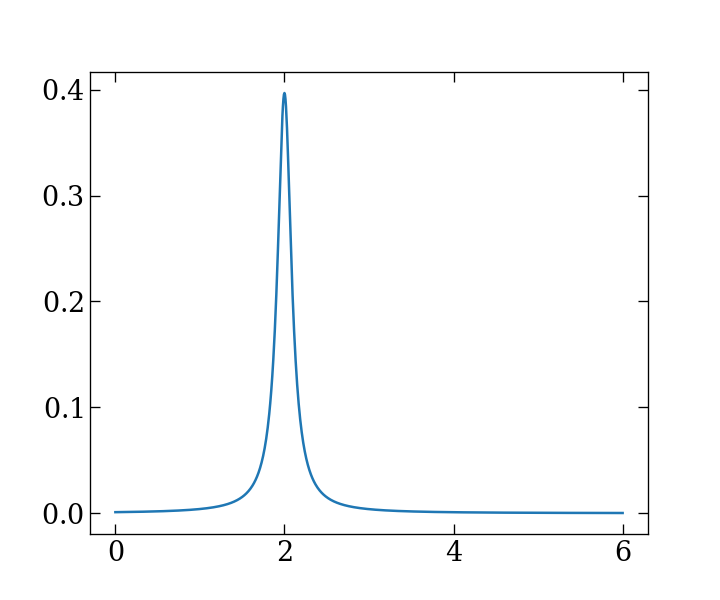

IndexError: list index out of range

In [8]:

# Theoretical Diffusion coefficient
X = Qp*sigma_dpp/Qs *1
print('X',X)
factors,orders = find_DiffusionSidebandWeight(X,maxOrder=30)
print('factors:',factors)
print('orders: ',orders)

dt = 1 # time between kicks
PSD_noise =  delta_n**2 /dt 
Jtest = np.linspace(0,1,1000) * 6
freq = Qx + a * Jtest

DD = np.zeros_like(freq)
for m in orders:
    for sign in [-1,1][m==0:]:
        Qcom = ReQ+sign*m*Qs + 1j*ImQ
        DD += factors[m] * PSD_noise/(2) * \
                np.abs(Qcom)**2/(pi2**2*((freq**2-np.real(Qcom**2))**2+np.imag(Qcom**2)**2)) 
# plt.figure()
plt.figure()
ax1 = plt.gca()
ax1.plot(Jtest,DD,label='Theory')


# Numerical 
label = r'$\langle \Delta J^2\rangle\,/\,2TJ_0$'
ax1.plot(xs1[-1],vars1[-1]/(turns1[-1]*2*xs1[0]),label=label)#'Turn=%d'%(turns1[-1]))


plt.grid(True)
plt.xlabel(r'$J_x$')
plt.ylabel(r'$D_{xx}$ [/turn]')
plt.legend(loc=0)
plt.xlim(0,6)
# plt.xlim(2,4)
plt.tight_layout()

# Plot for lebedev study

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


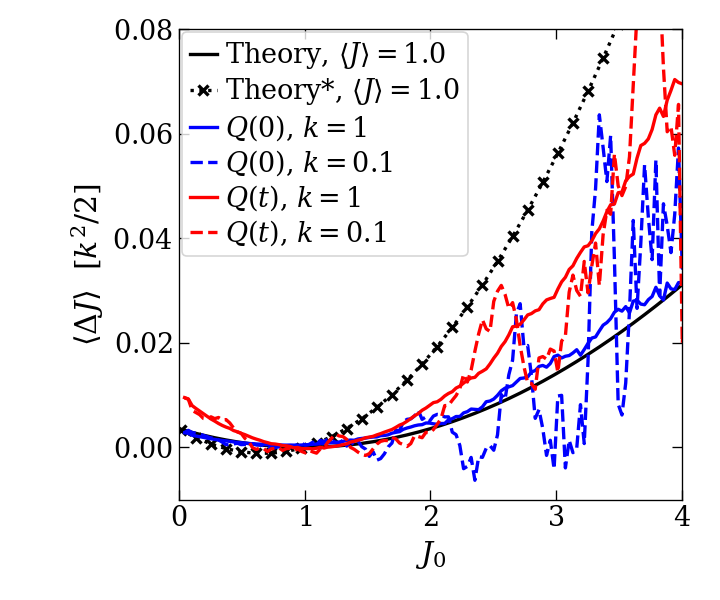

<IPython.core.display.Javascript object>


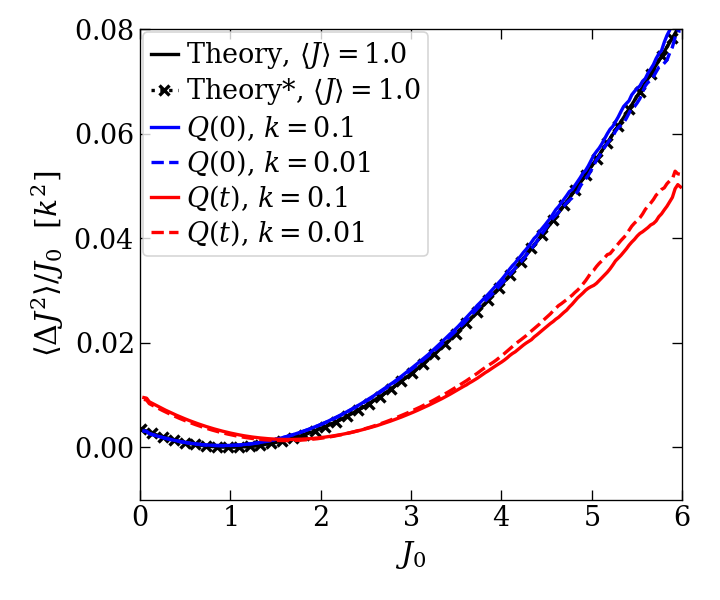

/home/sfuruset/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sfuruset/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


01_Output/LebDiffScan/djxdjx0_dx1e+00_D0e+00_g1e-01_a5e-04_b0e+00_J(t)0_Np1e+07
g 0.1 0.10000000000000002
D 1.0 0.0 0 0.5
01_Output/LebDiffScan/djxdjx0_dx4e-01_D0e+00_g1e-01_a5e-04_b0e+00_J(t)0_Np1e+07
Could not find it...
01_Output/LebDiffScan/djxdjx0_dx1e-01_D0e+00_g1e-01_a5e-04_b0e+00_J(t)0_Np1e+07
g 0.1 0.10000000000000002
D 0.1 0.0 0 0.005000000000000001
01_Output/LebDiffScan/djxdjx0_dx4e-02_D0e+00_g1e-01_a5e-04_b0e+00_J(t)0_Np1e+07
Could not find it...
01_Output/LebDiffScan/djxdjx0_dx1e-02_D0e+00_g1e-01_a5e-04_b0e+00_J(t)0_Np1e+07
g 0.1 0.10000000000000002
D 0.01 0.0 0 5e-05
01_Output/LebDiffScan/djxdjx0_dx1e+00_D0e+00_g1e-01_a5e-04_b0e+00_J(t)1_Np1e+07
g 0.1 0.10000000000000002
D 1.0 0.0 0 0.5
01_Output/LebDiffScan/djxdjx0_dx4e-01_D0e+00_g1e-01_a5e-04_b0e+00_J(t)1_Np1e+07
Could not find it...
01_Output/LebDiffScan/djxdjx0_dx1e-01_D0e+00_g1e-01_a5e-04_b0e+00_J(t)1_Np1e+07
g 0.1 0.10000000000000002
D 0.1 0.0 0 0.005000000000000001
01_Output/LebDiffScan/djxdjx0_dx4e-02_D0e+00_g1e-0

In [71]:
# sep = 0.2
if 0:
    a=1e-4
    b=-0*1.0
    g=0.02
    sep=0.2
    D=1e-4 *0
elif 1:
    a=5e-4
    b=0
    g=0.1
    sep=0.01
    D=1e-4 *0
mJy=mJx=1.

# Plot comparison of J and J0
def mean_nabo(f,n=3):
    g = np.zeros_like(f)
    for i in range(n):
        g[i] = np.mean(f[:i])
        g[-i-1] = np.mean(f[-(i+1):])
        
        g[n:-n] += np.roll(f,i+1)[n:-n]
        g[n:-n] += np.roll(f,-(i+1))[n:-n]
    g[n:-n] += f[n:-n]
    g[n:-n] = g[n:-n]/(2*n+1)
    return g
    
fig1=plt.figure(figsize=(figwidth,figheight*1))
fig1.patch.set_alpha(0)
ax1 = plt.subplot(111)
fig2=plt.figure(figsize=(figwidth,figheight*1))
fig2.patch.set_alpha(0)
ax2 = plt.subplot(111)

cs= ['r','b']
labs = [r'$Q(J_{x},J_{y})$',r'$Q(J_{x0},J_{y0})$']
# labs = [r'$\mu(t)$',r'$\mu(0)$']
labs = [r'$Q(t)$',r'$Q(0)$']

for i in [1,0]:  # Q(0) or Q(t)  = 1
    cnt=0
#     for j,Np in enumerate([1e5,1e6,1e7]):
#         label = labs[i]+', '+r'$N$=' + sci_not(Np,0)
    for j , jsep in enumerate([1,0.4,0.1,0.04,0.01,]):
        Np=1e7
        label = labs[i]+', '+r'$k=%.*f$'%(4-int(np.log10(jsep*1e4)),jsep)#+ sci_not(jsep,0)
        
        
    #     [ax,bx,cx] = np.loadtxt('djxdjx0_%d'%i)
        try:
#             fn = 'djxdjx0_%d_%.0e'%(i,Np)
#             fn = 'djxdjx0_%d_%.0e_%.0e_%.0e'%(i,g,a,Np)
#             fn = 'djxdjx0_%d_%.0e_%.0e_%.0e_%.0e'%(i,sep,g,a,Np)
#             fn = 'djxdjx0_%.0e_%.0e_%.0e_%.0e_%d_%.0e'%(sep,D,g,a,i,Np)
            fn = dir_save+'LebDiffScan/'+'djxdjx0_dx%.0e_D%.0e_g%.0e_a%.0e_b%.0e_J(t)%d_Np%.0e'%(jsep,D,g,a,b,1-i,Np)
            print(fn)
            with open(fn,'rb') as file:
                [ax,bx,vx,cx,par] = pkl.load(file)
            aj,bj,gj,sepj,Dj,TTj = par
            
            g0growth =0.5*sepj**2+ 0.5*Dj**2/3 * TTj # = 0.5 sep^2 -> L = sep*np.sqrt(3/TT)
            ksquare = 2*g0growth
            geff = gj**2/(gj + 10.3*aj*0)
            print('g',gj,geff)
            print('D',sepj,Dj,TTj,g0growth)
            
            fac = [2*g0growth,1][1]
            
            
            
            if cnt==0 and 1:
                for imJ in range(1):
                    if i==0: continue
                    mJ = [1, 1][i]
#                     f = anal_dJxdJx_octu( ax,aj,bj,geff,mJ,mJ) * fac
                    dmu = pi2*aj*(ax-1)
                    dmu2= pi2*aj*(ax-1.8)
                    f = LL(gj/2,dmu)
                    f1= f + dLLdm(gj/2,dmu) *pi2*aj*ax 
#                     f1 = f+ (LL(gj/2,dmu+1e-3)-LL(gj/2,dmu-1e-3))/2e-3*pi2*aj*ax
                    f2= f #- dLLdm(gj/2,dmu) *pi2*aj *0.5
                    th2 = [cx,f][1]
                    th1 = (f[1:]+f[:-1])/2+np.diff(f)/np.diff(ax)
                    
#                     if i>0:
#                         ax1.plot(ax,th2,'k',lw=2,ls=['--','-'][i],label=r'Theory, $\langle J\rangle=%.1f$'%(mJ))
#                         ax2.plot(ax,f2,'k',lw=2,ls=['--','-'][i],label=r'Theory, $\langle J\rangle=%.1f$'%(mJ))
# #                     ax2.plot(ax,th2,'k',lw=2,ls=['--','-'][i],label=r'Theory, $\langle J\rangle=%.1f$'%(mJ))
                    temp=i
                    for i in [1,0]:
                        ind = slice(0,-1,1+3*(i==0))
                        ax1.plot(ax[ind],[f1,f][i][ind],'k',lw=2,ls=[':','-'][i],marker=['x',''][i],label=r'Theory%s, $\langle J\rangle=%.1f$'%(['*',''][i],mJ))
                        ax2.plot(ax[ind],f2[ind],'k',lw=2,ls=[':','-'][i],marker=['x',''][i],label=r'Theory%s, $\langle J\rangle=%.1f$'%(['*',''][i],mJ))
                    i=temp

            #     plt.plot(ax,bx,cs[i])
#             plt.plot(mean_nabo(ax),mean_nabo(bx),cs[i],ls=[':','--','-'][j],label=labs[i]+', '+r'$N$=' + sci_not(Np,0))
            
            lss = ['-','--','-.']
            if j in [2,4]: ax2.plot((ax),mean_nabo((vx+0*bx**2)/ax)*fac/(ksquare),cs[i],lw=2,ls=lss[cnt-1],label=label)
            cnt+=1
            if j in [0,2]: ax1.plot((ax),mean_nabo(bx)*fac/(ksquare/2),cs[i],lw=2,ls=lss[cnt-1],label=label)
            
        #     plt.plot(ax,cx,cs[i],label=[None,'Theory'][i])
            
        except:
            print('Could not find it...')
            None

f = anal_dJxdJx_octu( ax,aj,bj,geff,mJx,mJy) * fac/2

for i,axi in enumerate([ax1,ax2]):
    axi.set_xlabel(r'$J_{0}$')
    axi.set_ylabel([r'$ \langle \Delta J \rangle $',r'$ \langle \Delta J^2 \rangle/J_{0} $'][i])
    axi.set_ylabel([r'$ \langle \Delta J \rangle $  $\left[k^2/2\right]$',r'$ \langle \Delta J^2 \rangle/J_{0} $  $[k^2]$'][i])
#     axi.grid(True)
    axi.legend(loc=0)
    xmax = [4,6][i]
    if np.any(ax>(xmax-0.1)):
        th6 = f[ax>xmax-0.1][0]
    axi.axis([0,xmax,-0.5*th6,2*th6])

    #     axi.axis([0,6,-0.001,0.016])
    figi = [fig1,fig2][i]
    figi.tight_layout()

ax1.axis([0,4,-0.01,0.08])
ax2.axis([0,6,-0.01,0.08])
    
sepj=-1
fig1.savefig('03_Plots/DACT^1_dx%.0e_D%.0e_g%.0e_a%.0e_b%.0e_Np%.0e.eps'%(sepj,Dj,gj,aj,bj,Np))
fig2.savefig('03_Plots/DACT^2_dx%.0e_D%.0e_g%.0e_a%.0e_b%.0e_Np%.0e.eps'%(sepj,Dj,gj,aj,bj,Np))

In [318]:
xx = 0.1234
(np.log10(.4))
(np.log10(.1))

-1.0

In [92]:
cc = np.arange(10)
print(cc, cc[1:-0])

[0 1 2 3 4 5 6 7 8 9] []


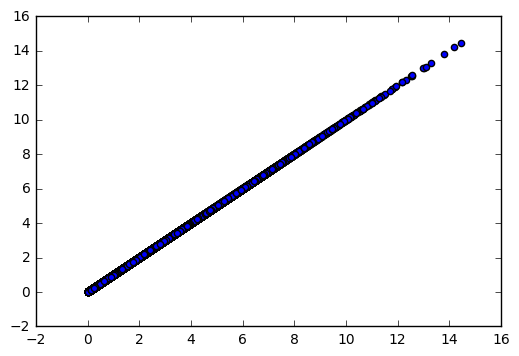

In [1445]:
plt.figure()
plt.scatter(jz0,jz)

In [916]:
def dist_j(J):
    return np.exp(-J)
scipy.integrate.quad(dist_j,0,6)[0]

0.9975212478233337

# COM motion with kicks

Analytical prefactor  = 0.577
Curve-fit prefact     = 0.699
Analytical equilibrium= 4.082
Curve-fit equilibrium = 4.108


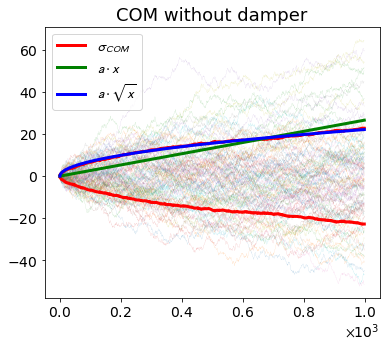

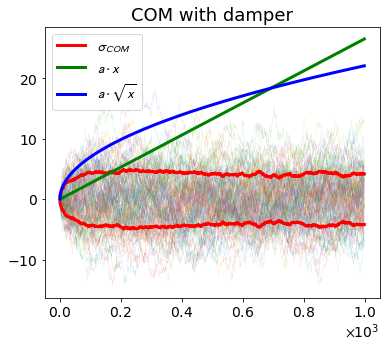

In [7]:
nt = 1000
t = np.arange(nt)
n = 100
L=1
sig = L/np.sqrt(3)
kicks = np.random.uniform(-L,L,(n,nt))
# kicks = np.random.normal(0,sig,(n,nt))
com = np.cumsum(kicks,axis=1).transpose()
std_com = np.std(com,axis=1)

def f1(x,a):
    return x*a
def f2(x,a):
    return a*np.sqrt(x)
fit1,_ = scipy.optimize.curve_fit(f1,t, std_com)
fit2,_ = scipy.optimize.curve_fit(f2,t, std_com)


plt.figure()
plt.plot(com,'--',lw=0.1)
plt.plot(std_com,'r',lw=3,label=r'$\sigma_{COM}$')
plt.plot(-std_com,'r',lw=3)
plt.plot(t,f1(t,fit1),'g',lw=3,label=r'$a\cdot x$')
plt.plot(t,f2(t,fit2),'b',lw=3,label=r'$a\cdot \sqrt{x}$')
plt.title('COM without damper')
plt.legend(loc=0)
#######################
tau = 100
com2 = np.zeros_like(com)
for i,ti in enumerate(t):
    ts = (ti-t)[:i+1]
    fac =np.exp(-ts/tau)
#     if i<10:
#         print(fac)
#         print(ts)
    com2[i,:] = np.sum(kicks[:,:i+1]*fac,axis=1)
std_com2 = np.std(com2,axis=1)


##################
# tau = 100
# g = 2/tau
# com2 = np.zeros_like(com)
# x = np.zeros(n)
# for i,ti in enumerate(t):
    

# fit1,_ = scipy.optimize.curve_fit(f1,t, std_com2)
# fit2,_ = scipy.optimize.curve_fit(f2,t, std_com2)


plt.figure()
plt.plot(com2,'--',lw=0.1)
plt.plot(std_com2,'r',lw=3,label=r'$\sigma_{COM}$')
plt.plot(-std_com2,'r',lw=3)
plt.plot(t,f1(t,fit1),'g',lw=3,label=r'$a\cdot x$')
plt.plot(t,f2(t,fit2),'b',lw=3,label=r'$a\cdot \sqrt{x}$')
plt.title('COM with damper')
plt.legend(loc=0)
print('Analytical prefactor  = %.3f'%(L/np.sqrt(3)))
print('Curve-fit prefact     = %.3f'%fit2)
print('Analytical equilibrium= %.3f'%(L/np.sqrt(3)*np.sqrt(tau*0.5)))
print('Curve-fit equilibrium = %.3f'%np.mean(std_com2[int(nt*0.5):]))

# print(com.shape)
# print(com2.shape)
# print(com2)
# print(std_com)
# print(std_com2)
# print(fac)
# print(ts)

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


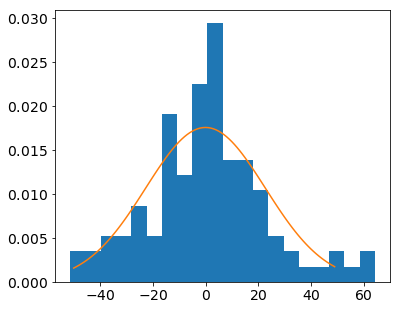

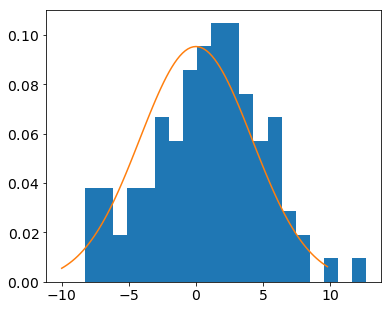

In [8]:
x = np.arange(-50,50)
plt.figure()
plt.hist(com[-1,:],bins=20,normed=True)
plt.plot(x,st.norm.pdf(x/std_com[-1])/std_com[-1])
x=x/5
plt.figure()
plt.hist(com2[-1,:],bins=20,normed=True)
plt.plot(x,st.norm.pdf(x/std_com2[-1])/std_com2[-1])



# Transition to 2D

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Analytical prefactor    = 0.577
Curve-fit prefact       = 0.119
Analytical equilibrium r= 4.082
Analytical equilibrium x= 2.887
Curve-fit equilibrium   = 2.842


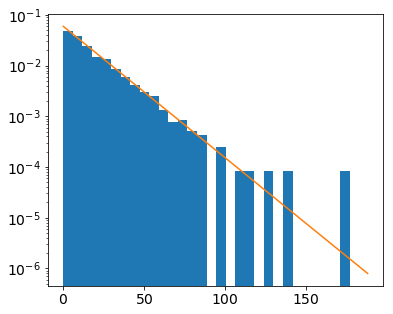

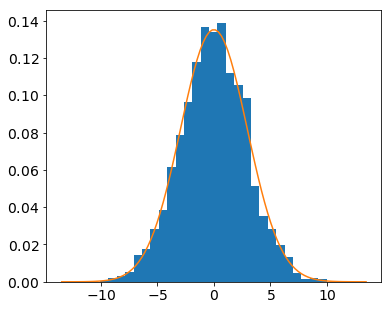

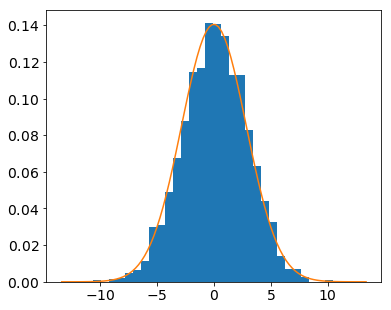

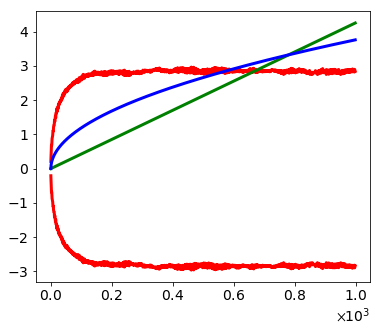

In [9]:
tau = 100
g = 2/tau
mu = 2*np.pi*0.31
C = np.cos(mu)
S = np.sin(mu)
nt = 1000
t = np.arange(nt)
n = 2000
comx = np.zeros((nt,n))
comp = np.zeros((nt,n))
x = np.zeros(n)
p = np.zeros(n)

############################
######## tracking ##########
for i,ti in enumerate(t):
    p += np.random.uniform(-L,L,n)
    temp = x
    x = C*x + S*p
    p = -S*temp+C*p
    
    p -= g*p
    
    comx[i,:]=x
    comp[i,:]=p
    
    
std_comx = np.std(comx,axis=1)
std_comp = np.std(comp,axis=1)



# com=comp
# std_com = np.std(com,axis=1)
d = 1
com2d     = np.sqrt(comx**2+   d*   comp**2)    
std_com2d = np.sqrt(np.mean(com2d**2,axis=1))

com2d_sq     = comx**2 +   d*   comp**2
std_com2d_sq = (np.mean(com2d_sq,axis=1))/(1+d)

# print('test',np.all(std_com2d_sq==std_com2d_sq1))
# print(std_com2d_sq)
# print(std_com2d_sq1)

# maxx = np.max(np.abs(std_com))
# x = np.arange(0,maxx)
# plt.figure()
# plt.hist(com[-1,:],bins=20,normed=True)
# plt.plot(x,st.chi2.pdf(x,2))
# plt.plot(x,st.norm.pdf(x/std_com[-1])/std_com[-1])

if False:
    plt.figure()
    plt.hist2d(comx[-1,:],comp[-1,:])


coms = [comx,comp,        com2d    ,com2d_sq]
stds = [std_comx,std_comp,std_com2d,std_com2d_sq]
for i in [3,0,1]:
    comi = coms[i]
    std_comi = stds[i]
    maxx = np.max(np.abs(comi))
    plt.figure()
    
    plt.hist(comi[-1,:],bins=30,normed=True)
    
    if np.any(comi<0):
        x = np.linspace(-maxx,maxx,100)
        plt.plot(x,st.norm.pdf(x/std_comi[-1])/std_comi[-1])
    else:
        x = np.linspace(0,maxx,100)
#         plt.plot(x,st.chi2.pdf(x/std_comi[-1],2)/std_comi[-1])
        
        f = 1
        plt.plot(x,st.chi2.pdf( x/std_comi[-1]**f ,1+d)/std_comi[-1]**f)
#         plt.plot(x,st.chi2.pdf( x,1))
        plt.yscale('log')
    

i=1
comi = coms[i]
std_comi = stds[i]
    
    
fit1,_ = scipy.optimize.curve_fit(f1,t, std_comi)
fit2,_ = scipy.optimize.curve_fit(f2,t, std_comi)

plt.figure()
# plt.plot(comi,'--',lw=0.1)
plt.plot( std_comi,'r',lw=3)
plt.plot(-std_comi,'r',lw=3)
plt.plot(t,f1(t,fit1),'g',lw=3)
plt.plot(t,f2(t,fit2),'b',lw=3)


print('Analytical prefactor    = %.3f'%(L/np.sqrt(3)  ))
print('Curve-fit prefact       = %.3f'%fit2)
print('Analytical equilibrium r= %.3f'%(L/np.sqrt(3)*np.sqrt(tau*0.5)))
print('Analytical equilibrium x= %.3f'%(L/np.sqrt(3)*np.sqrt(tau*0.5*0.5)))
print('Curve-fit equilibrium   = %.3f'%np.mean(std_comi[int(nt*0.5):]))


# Other stuff

In [636]:
c[0,:]

array([ 0.,  1.,  2.])

In [685]:
st.norm.pdf(3)

0.0044318484119380075

NameError: name 'np' is not defined